In [26]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [27]:
im_shape = (200,200)
TRAINING_DIR = "/home/krishnatejaswis/VSCode/Lung_Scan_Detection/data/train"
VAL_DIR = "/home/krishnatejaswis/VSCode/Lung_Scan_Detection/data/val"
TEST_DIR = "/home/krishnatejaswis/VSCode/Lung_Scan_Detection/data/test"

In [28]:
seed  =10
BATCH_SIZE =16

In [29]:
# data_generator = ImageDataGenerator(
#        validation_split=0.2, rotation_range=5, width_shift_range=0.05,
#        height_shift_range=0.05, preprocessing_function=preprocess_input,
#        zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

# Image dataset 
# Without augmentation
# For augmentation add the parameters inside data_generator function as follows  or replace the code snippet :
"""data_generator = ImageDataGenerator(validation_split=0.0001,preprocessing_function=preprocess_input,horizontal_flip=True,rotation_range=6,zoom_range=[0.96,1.0])"""
data_generator = ImageDataGenerator(validation_split=0.0001,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.99)

In [30]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(VAL_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 6326 images belonging to 4 classes.
Found 34 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


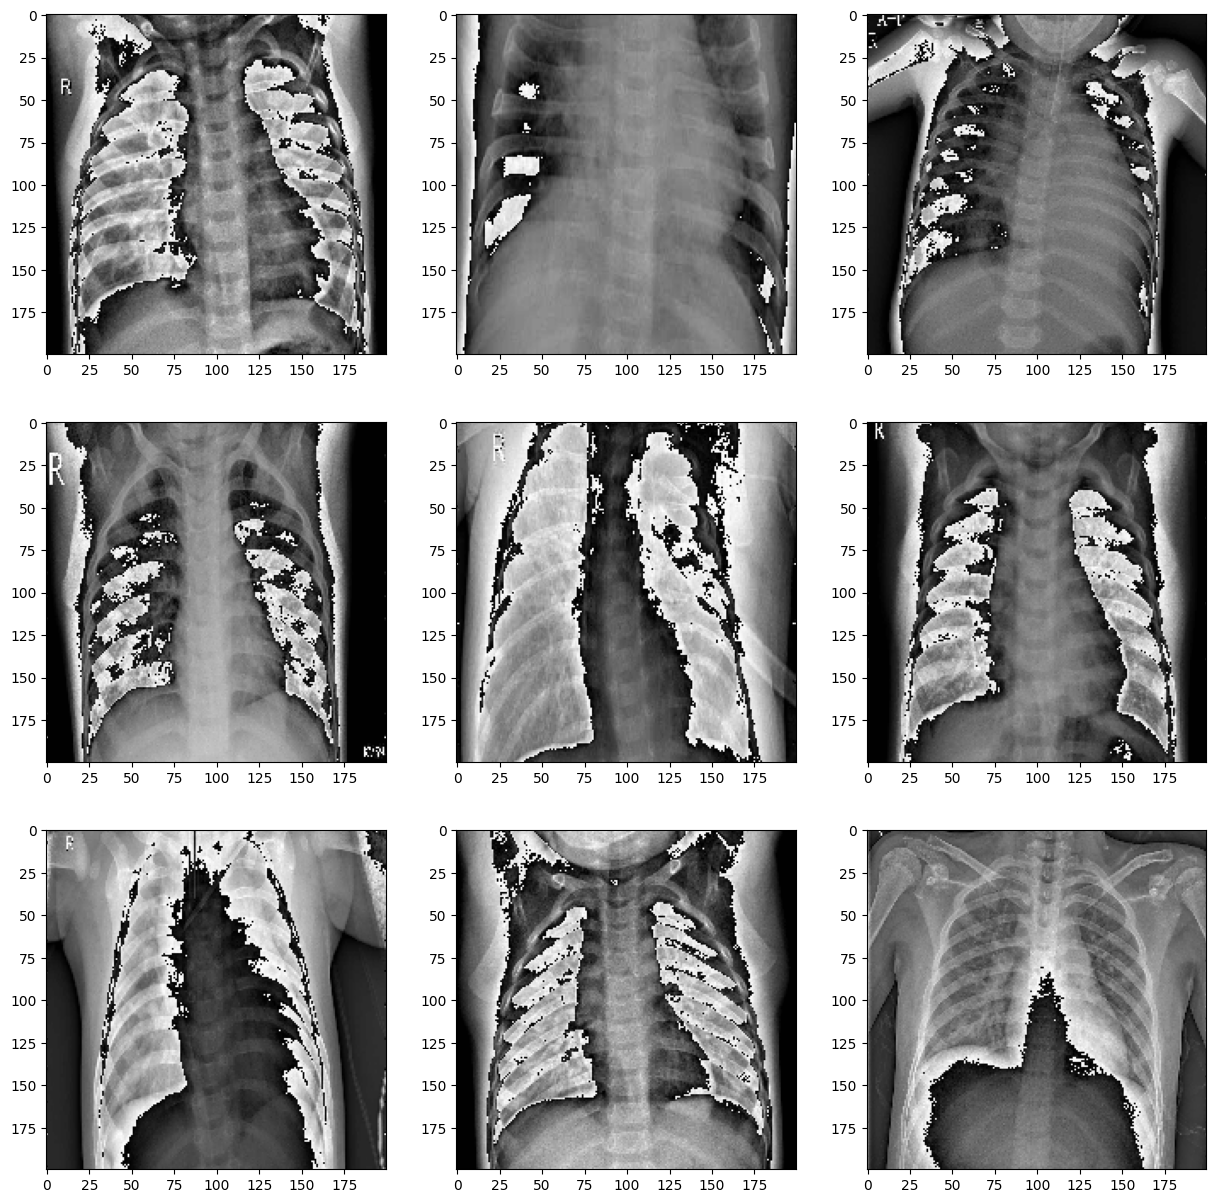

In [31]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [33]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(80, activation='relu')(x)
x= Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

modeltrf = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
modeltrf.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/home/krishnatejaswis/VSCode/Lung_Scan_Detection/TransLearnNormalEighty.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = modeltrf.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/15
395/395 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8363
Epoch 1: val_loss improved from inf to 0.77604, saving model to /home/krishnatejaswis/VSCode/Lung_Scan_Detection/TransLearnNormalEighty.h5
395/395 [==============================] - 63s 135ms/step - loss: 0.4480 - accuracy: 0.8363 - val_loss: 0.7760 - val_accuracy: 0.7812
Epoch 2/15
395/395 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8962
Epoch 2: val_loss improved from 0.77604 to 0.71969, saving model to /home/krishnatejaswis/VSCode/Lung_Scan_Detection/TransLearnNormalEighty.h5
395/395 [==============================] - 51s 129ms/step - loss: 0.2601 - accuracy: 0.8962 - val_loss: 0.7197 - val_accuracy: 0.7500
Epoch 3/15
395/395 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9008
Epoch 3: val_loss improved from 0.71969 to 0.52259, saving model to /home/krishnatejaswis/VSCode/Lung_Scan_Detection/TransLearnNormalEighty.h5
395/395 [==========

In [35]:
score = modeltrf.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.9860080480575562
Val accuracy: 0.8529411554336548


In [36]:
# Using the test dataset
score = modeltrf.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6256572008132935
Test accuracy: 0.8651102185249329


<class 'list'>


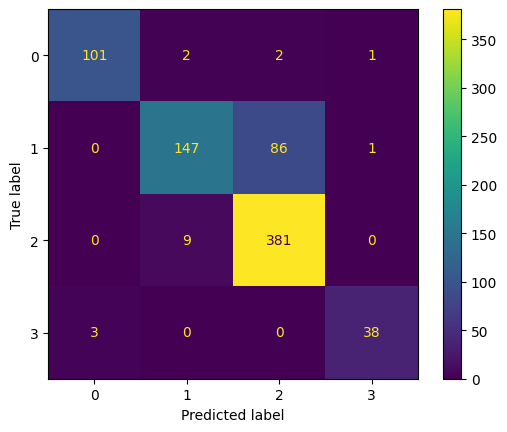

Classification Report
               precision    recall  f1-score   support

      COVID19       0.97      0.95      0.96       106
       NORMAL       0.93      0.63      0.75       234
    PNEUMONIA       0.81      0.98      0.89       390
TURBERCULOSIS       0.95      0.93      0.94        41

     accuracy                           0.87       771
    macro avg       0.92      0.87      0.88       771
 weighted avg       0.88      0.87      0.86       771



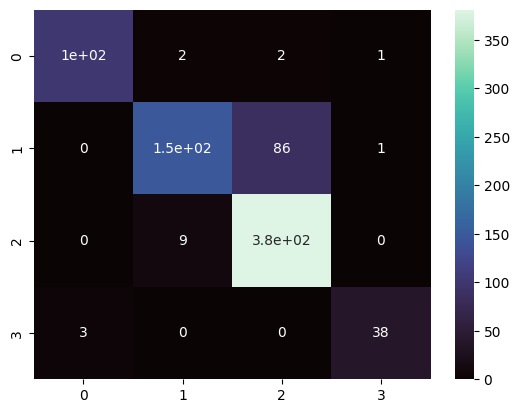

In [37]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
from sklearn import metrics
import matplotlib.pyplot as plt



#Confution Matrix and Classification Report
Y_pred = modeltrf.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes
print(type(target_names))

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()
MAP1 = sn.heatmap(cm,annot=True,cmap='mako')

#plotconfusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

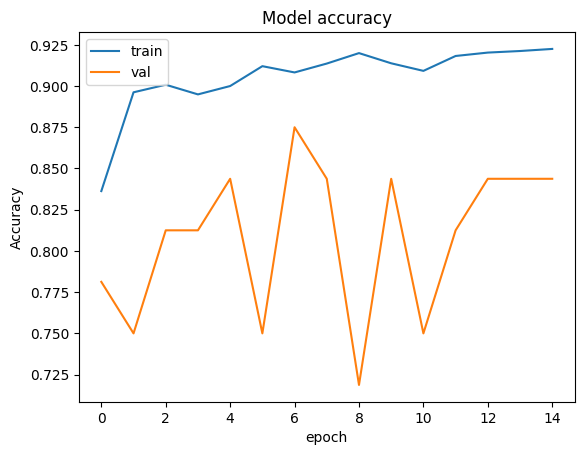

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

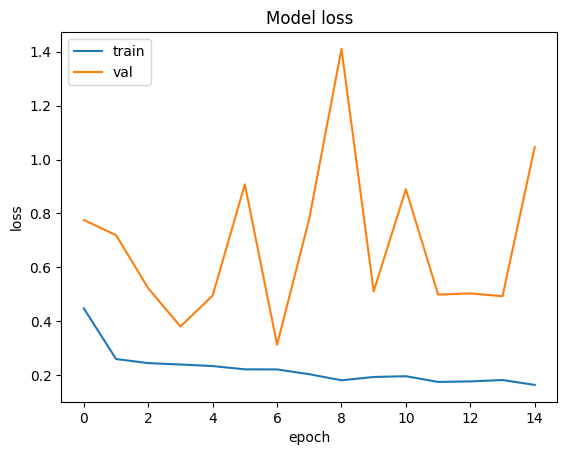

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()


In [40]:
model_json = modeltrf.to_json()
with open("lungs_model.json", "w") as json_file:
    json_file.write(model_json)
modeltrf.save_weights("/home/krishnatejaswis/VSCode/Lung_Scan_Detection/TransLearnNormalEighty.h5")
print("Model Saved to the disk")

Model Saved to the disk
